# Packages

In [1]:
%pip install pyarrow
%pip install ipywidgets
%pip install ipympl
%pip install tqdm
%matplotlib widget


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import ipywidgets as widgets
import numpy as np
from tqdm import tqdm

# Load data

In [3]:
df_file = pd.read_parquet(r"E:\00_Thesis\01_Datenaufbereitung\Output\Calculated\df_15.parquet")
df_file['Absolute_Time[yyyy-mm-dd hh:mm:ss]'] = pd.to_datetime(df_file['Absolute_Time[yyyy-mm-dd hh:mm:ss]'])

# Plot SOC SOH

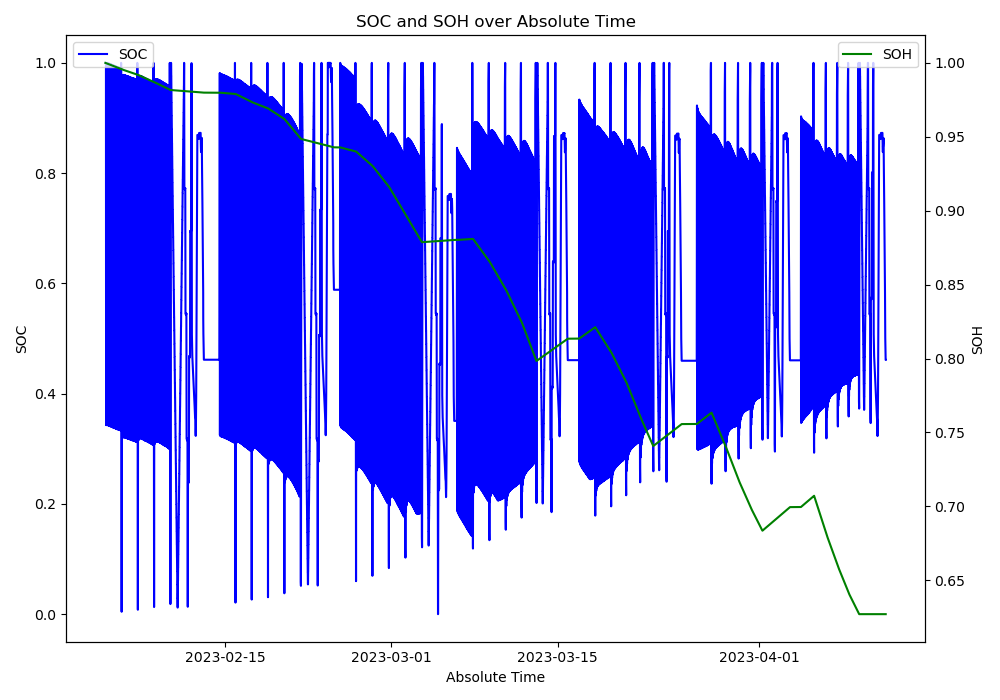

In [4]:
fig, ax1 = plt.subplots(figsize=(10, 7))

ax1.set_xlabel('Absolute Time')
ax1.set_ylabel('SOC')
ax1.plot(df_file['Absolute_Time[yyyy-mm-dd hh:mm:ss]'], df_file['SOC_ZHU'], color='blue', label='SOC')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.set_ylabel('SOH')
ax2.plot(df_file['Absolute_Time[yyyy-mm-dd hh:mm:ss]'], df_file['SOH_ZHU'], color='green', label='SOH')
ax2.legend(loc='upper right')

plt.title("SOC and SOH over Absolute Time")
plt.xticks(rotation=45)
fig.tight_layout()  
plt.show()

## Calculation

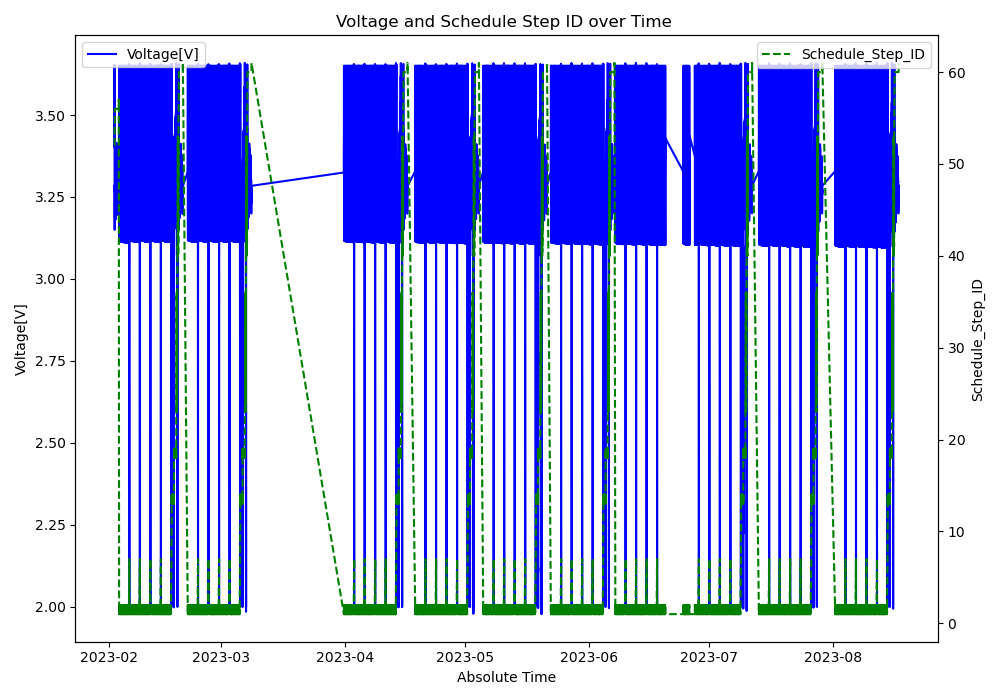

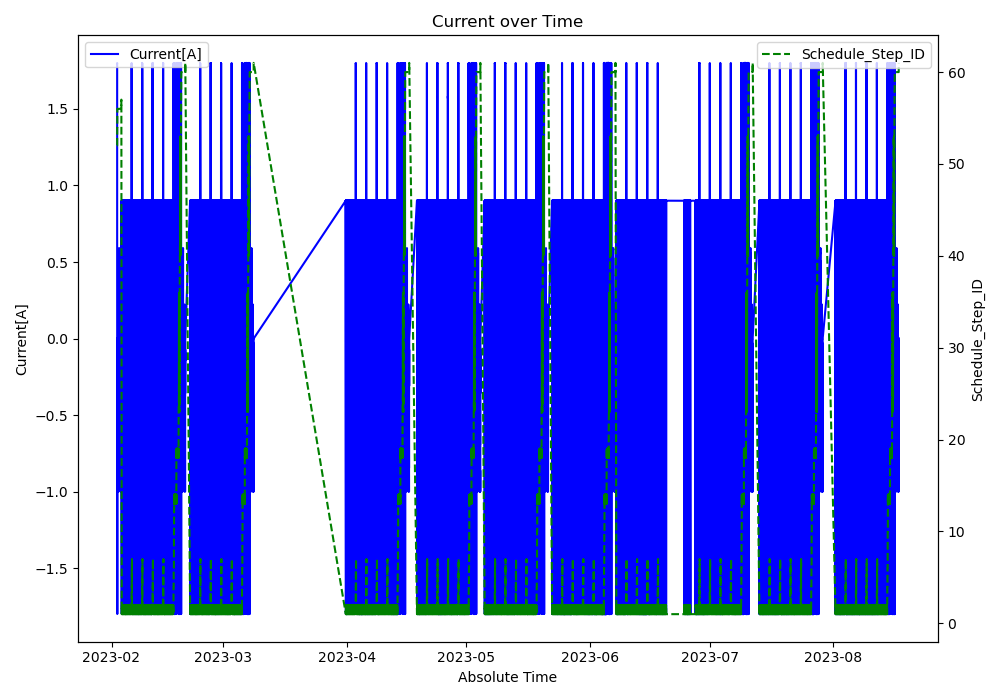

In [9]:
# According to ID
filtered_data = df_file
# First Plot -- Voltage and Schedule Step ID
fig, ax1 = plt.subplots(figsize=(10, 7))
ax1.set_xlabel('Absolute Time')
ax1.set_ylabel('Voltage[V]')
ax1.plot(filtered_data['Absolute_Time[yyyy-mm-dd hh:mm:ss]'], filtered_data['Voltage[V]'], color='blue', label='Voltage[V]')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.set_ylabel('Schedule_Step_ID')
ax2.plot(filtered_data['Absolute_Time[yyyy-mm-dd hh:mm:ss]'], filtered_data['Schedule_Step_ID'], color='green', label='Schedule_Step_ID', linestyle='--')
ax2.legend(loc='upper right')

plt.title(f'Voltage and Schedule Step ID over Time ')
plt.tight_layout()
plt.show()

# Second Plot -- Current
fig2, ax3 = plt.subplots(figsize=(10, 7))
ax3.set_xlabel('Absolute Time')
ax3.set_ylabel('Current[A]')
ax3.plot(filtered_data['Absolute_Time[yyyy-mm-dd hh:mm:ss]'], filtered_data['Current[A]'], color='blue', label='Current[A]')
ax3.legend(loc='upper left')

ax4 = ax3.twinx()
ax4.set_ylabel('Schedule_Step_ID')
ax4.plot(filtered_data['Absolute_Time[yyyy-mm-dd hh:mm:ss]'], filtered_data['Schedule_Step_ID'], color='green', label='Schedule_Step_ID', linestyle='--')
ax4.legend(loc='upper right')

plt.title(f'Current over Time')
plt.tight_layout()
plt.show()



### SOH SOC calculation
1. SOH 
- Start ID 1 End ID 7
- Compte original Capacity using fully discharge time

    $Capacity(Ah)=∫_{t0}^{t1}I(t)t$

- Compute current Capacity
- Compute SOH

    $ SOH = \frac{C_{\text{current}}}{C_{\text{initial}}}$

2. SOC
- Find the start of SOC(0) = 1
- Compute SOC
 
    $SOC(t) = SOC(0) + \frac{1}{C_{nom}} \int_0^t I(t)dt *100$ 

In [11]:
# Set start and end time
start_time = df_file['Absolute_Time[yyyy-mm-dd hh:mm:ss]'].min()
end_time = df_file['Absolute_Time[yyyy-mm-dd hh:mm:ss]'].max()

filtered_data = df_file[
    (df_file['Absolute_Time[yyyy-mm-dd hh:mm:ss]'] >= start_time) &
    (df_file['Absolute_Time[yyyy-mm-dd hh:mm:ss]'] <= end_time)
]

# dt 
filtered_data['Time_diff'] = filtered_data['Testtime[s]'].diff() / 3600
filtered_data.loc[filtered_data['Time_diff'].abs() > 0.5, 'Time_diff'] = 0
filtered_data.fillna({'Time_diff':0}, inplace=True)

# Parameter initialize SOH
C_initial = None
C_current = 0
soh_values = []

# Parameter initialize SOC
C_nom = None
filtered_data['SOC_ZHU'] = np.nan
soc_start = filtered_data.loc[filtered_data['Schedule_Step_ID'] == 5,'Absolute_Time[yyyy-mm-dd hh:mm:ss]'].iloc[0]
soc_init = 1
soc_values = []
soc_t0 = soc_init
V_max = filtered_data['Voltage[V]'].max() 
V_min = filtered_data['Voltage[V]'].min() 

# Compute SOH during fully discharge state [5,8)
for idx, row in tqdm(filtered_data.iterrows(), total=len(filtered_data), desc="Processing data"):
    # Calculate SOH
    # Fully discharge phase
    if row['Schedule_Step_ID'] in range(5, 8):  
        C_current += row['Current[A]'] * row['Time_diff']
        
    elif C_current != 0:
        #Set first fully discharge state as Initial
        if C_initial is None: 
            C_initial = C_current     
            C_nom = abs(C_initial)    
        # Calculate SOH after fully discharge
        soh_values.append((idx, C_current / C_initial))
        C_current = 0
     
    if row['Absolute_Time[yyyy-mm-dd hh:mm:ss]'] >= soc_start and C_nom:
    # Calculate SOC
        delta_soc = (row['Current[A]'] * row['Time_diff']) / C_nom 
        soc_t = soc_t0 + delta_soc
        # Reset SOC after CV phase from every Capacity test 
        if row['Schedule_Step_ID'] == 5:
            soc_t = 1.0  # Fully charged during CV phase
        elif row['Voltage[V]'] >= V_max:
            soc_t = 1.0  # SOC at 1.0 if voltage is at maximum
        elif row['Voltage[V]'] <= V_min:
            soc_t = 0.0  # SOC if voltage is at minimum

        soc_t = max(0.0, min(soc_t, 1.0))
        soc_values.append((idx, soc_t))
        soc_t0 = soc_t 

print(f"Original capacity: {abs(C_initial)} Ah") 

for idx, soh_value in tqdm(soh_values, total=len(soh_values), desc="Updating SOH"):
    filtered_data.loc[idx, 'SOH_ZHU'] = soh_value
    
filtered_data['SOH_ZHU'] = filtered_data['SOH_ZHU'].interpolate(method='linear')    

for idx, soc_value in tqdm(soc_values, total=len(soc_values), desc="Updating SOC"):
    filtered_data.loc[idx, 'SOC_ZHU'] = soc_value

filtered_data.to_parquet('df_29.parquet',index = False)
filtered_data

Processing data: 100%|██████████| 11204023/11204023 [17:29<00:00, 10680.40it/s]


Original capacity: 1.788689533333232 Ah


Updating SOC: 100%|██████████| 10995369/10995369 [27:56<00:00, 6560.04it/s]


,Absolute_Time[yyyy-mm-dd hh:mm:ss],Testtime[s],Step_ID,Schedule_Step_ID,Step_Time[s],Voltage[V],Current[A],Temperature[°C],Aux_U[V],Aux_I[A],...,Q_sum,Capacity[Ah],SOH,Q_c,EFC,SOC_c,SOC_m,Time_diff,SOC_ZHU,SOH_ZHU
159774,2023-02-02 09:05:31,161285.1,592,52,0.0,3.4148,1.8002,26.2,-0.0006,NaN,...,10.291816,1.788751,0.999975,-0.603174,5.753487,0.662805,0.675211,0.000000,NaN,NaN
159775,2023-02-02 09:05:32,161286.1,592,52,1.0,3.4312,1.8009,26.2,0.0006,NaN,...,10.292316,1.788751,0.999975,-0.602673,5.753767,0.663084,0.675491,0.000278,NaN,NaN
159776,2023-02-02 09:05:33,161287.1,592,52,2.0,3.4443,1.8009,26.4,-0.0006,NaN,...,10.292816,1.788751,0.999975,-0.602173,5.754047,0.663364,0.675770,0.000278,NaN,NaN
159777,2023-02-02 09:05:34,161288.1,592,52,3.0,3.4539,1.8009,26.4,-0.0006,NaN,...,10.293316,1.788751,0.999975,-0.601673,5.754326,0.663644,0.676050,0.000278,NaN,NaN
159778,2023-02-02 09:05:35,161289.1,592,52,4.0,3.4613,1.8009,26.2,-0.0006,NaN,...,10.293817,1.788751,0.999975,-0.601173,5.754606,0.663923,0.676330,0.000278,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11363792,2023-07-02 11:44:39,11350129.8,762,61,896.0,3.2198,0.0000,26.7,-0.0006,NaN,...,5270.992221,1.170713,0.654470,-0.975037,2946.670224,0.454920,0.966047,0.000278,0.454888,0.654509
11363793,2023-07-02 11:44:40,11350130.8,762,61,897.0,3.2195,0.0000,26.6,0.0006,NaN,...,5270.992221,1.170713,0.654470,-0.975037,2946.670224,0.454920,0.966047,0.000278,0.454888,0.654509
11363794,2023-07-02 11:44:41,11350131.8,762,61,898.0,3.2198,0.0000,26.5,-0.0006,NaN,...,5270.992221,1.170713,0.654470,-0.975037,2946.670224,0.454920,0.966047,0.000278,0.454888,0.654509
11363795,2023-07-02 11:44:42,11350132.8,762,61,899.0,3.2198,0.0000,26.7,-0.0006,NaN,...,5270.992221,1.170713,0.654470,-0.975037,2946.670224,0.454920,0.966047,0.000278,0.454888,0.654509


In [8]:
# Data filter
start_id_selector = widgets.Dropdown(
    options=sorted(df_file['Schedule_Step_ID'].unique()),
    description='Start ID:',
    disabled=False,
)
end_id_selector = widgets.Dropdown(
    options=sorted(df_file['Schedule_Step_ID'].unique()),
    description='End ID:',
    disabled=False,
)

# Data filter for start and end -- Time
min_time = df_file['Absolute_Time[yyyy-mm-dd hh:mm:ss]'].min()
max_time = df_file['Absolute_Time[yyyy-mm-dd hh:mm:ss]'].max()

start_time_selector = widgets.Dropdown(
    options=pd.date_range(min_time, max_time, freq='D').strftime('%Y-%m-%d %H:%M:%S'),
    description='Start Time:',
    disabled=False,
)
end_time_selector = widgets.Dropdown(
    options=pd.date_range(min_time, max_time, freq='D').strftime('%Y-%m-%d %H:%M:%S'),
    description='End Time:',
    disabled=False,
)

# Plot function
def soc_soh_plot(start_id, end_id, start_time, end_time):
    # According to ID
    filtered_data = df_file[(df_file['Schedule_Step_ID'] >= start_id) & 
                            (df_file['Schedule_Step_ID'] <= end_id)]
    # According to Time
    if start_time:
        filtered_data = filtered_data[filtered_data['Absolute_Time[yyyy-mm-dd hh:mm:ss]'] >= pd.Timestamp(start_time)]
    if end_time:
        filtered_data = filtered_data[filtered_data['Absolute_Time[yyyy-mm-dd hh:mm:ss]'] <= pd.Timestamp(end_time)]
    
    # First Plot -- Voltage and Schedule Step ID
    fig, ax1 = plt.subplots(figsize=(10, 7))
    ax1.set_xlabel('Absolute Time')
    ax1.set_ylabel('SOH')
    ax1.plot(filtered_data['Absolute_Time[yyyy-mm-dd hh:mm:ss]'], filtered_data['SOH_ZHU'], color='blue', label='SOH')
    ax1.legend(loc='upper left')
    
    ax2 = ax1.twinx()
    ax2.set_ylabel('Schedule_Step_ID')
    ax2.plot(filtered_data['Absolute_Time[yyyy-mm-dd hh:mm:ss]'], filtered_data['Schedule_Step_ID'], color='green', label='Schedule_Step_ID', linestyle='--')
    ax2.legend(loc='upper right')
    
    plt.title(f'Voltage and Schedule Step ID over Time (From ID {start_id} to {end_id})')
    plt.tight_layout()
    plt.show()

    # Second Plot -- Current
    fig2, ax3 = plt.subplots(figsize=(10, 7))
    ax3.set_xlabel('Absolute Time')
    ax3.set_ylabel('SOC')
    ax3.plot(filtered_data['Absolute_Time[yyyy-mm-dd hh:mm:ss]'], filtered_data['SOC_ZHU'], color='blue', label='SOC')
    ax3.legend(loc='upper left')

    ax4 = ax3.twinx()
    ax4.set_ylabel('Schedule_Step_ID')
    ax4.plot(filtered_data['Absolute_Time[yyyy-mm-dd hh:mm:ss]'], filtered_data['Schedule_Step_ID'], color='green', label='Schedule_Step_ID', linestyle='--')
    ax4.legend(loc='upper right')
    
    plt.title(f'Current over Time (From ID {start_id} to {end_id})')
    plt.tight_layout()
    plt.show()

# Widgets Interaction
widgets.interact(soc_soh_plot, start_id=start_id_selector, end_id=end_id_selector, start_time=start_time_selector, end_time=end_time_selector)

interactive(children=(Dropdown(description='Start ID:', options=(1, 2, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 16, …

<function __main__.soc_soh_plot(start_id, end_id, start_time, end_time)>

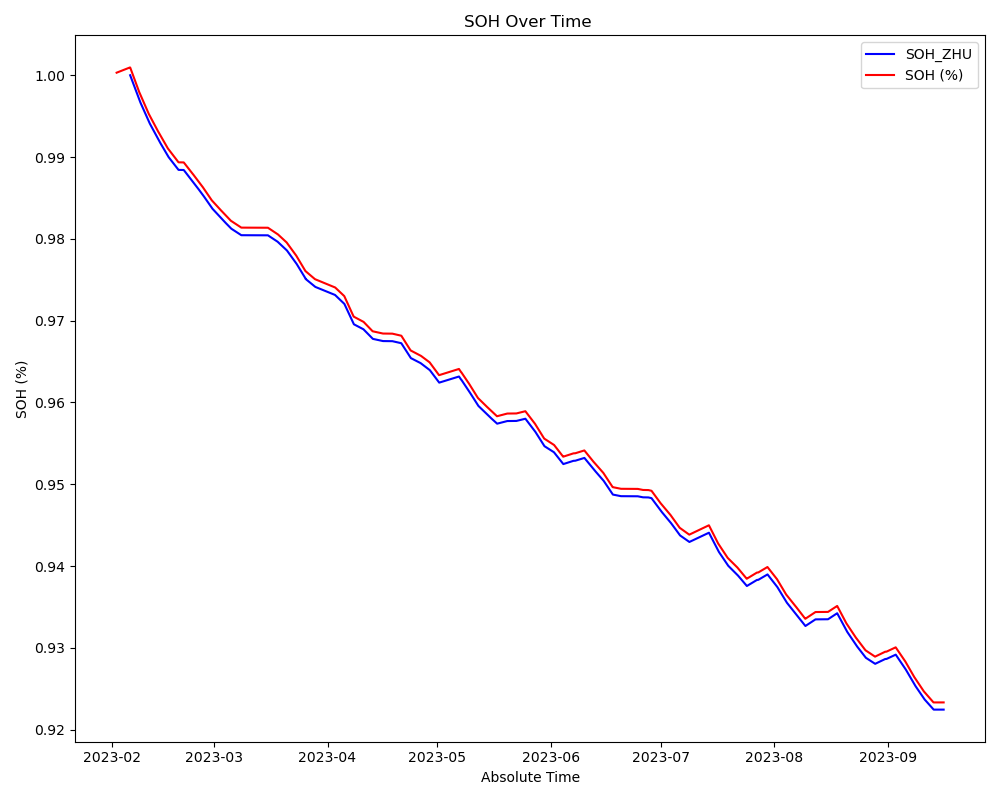

In [5]:
plt.figure(figsize=(10, 8))
plt.plot(filtered_data['Absolute_Time[yyyy-mm-dd hh:mm:ss]'], filtered_data['SOH_ZHU'], linestyle='-', color='blue', label='SOH_ZHU')
plt.plot(df_file['Absolute_Time[yyyy-mm-dd hh:mm:ss]'], df_file['SOH'], label='SOH (%)', color='red')
plt.xlabel('Absolute Time')
plt.ylabel('SOH (%)')
plt.title('SOH Over Time ')
plt.legend(loc="best")
plt.tight_layout()
plt.show()


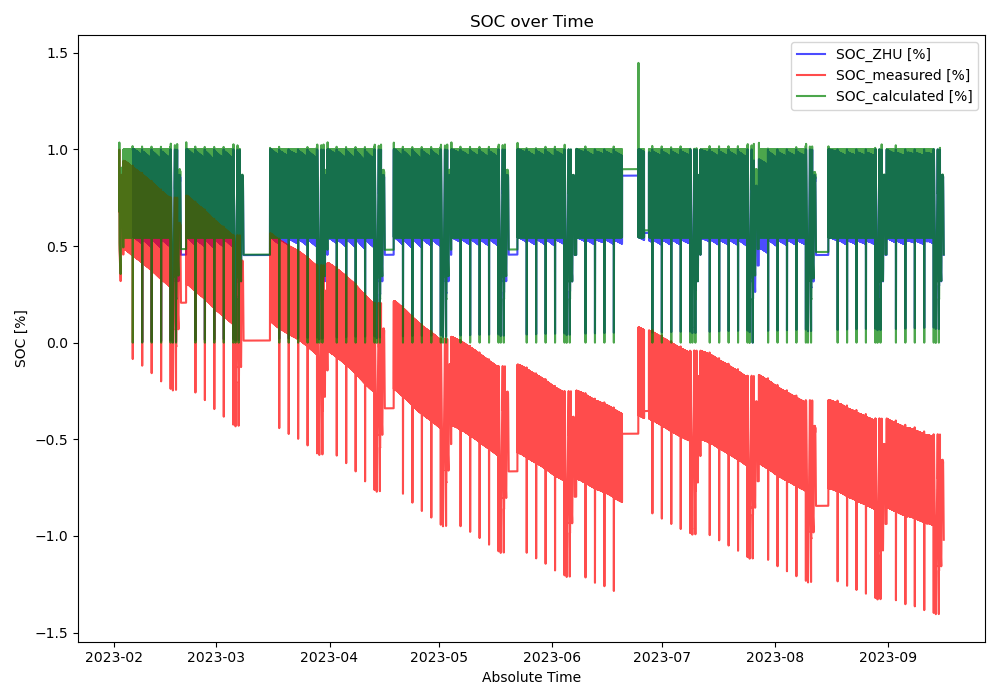

In [6]:
plt.figure(figsize=(10, 7))
plt.plot(filtered_data['Absolute_Time[yyyy-mm-dd hh:mm:ss]'], filtered_data['SOC_ZHU'], label='SOC_ZHU [%]', color='blue', alpha=0.7)
plt.plot(filtered_data['Absolute_Time[yyyy-mm-dd hh:mm:ss]'], filtered_data['SOC_m'], label='SOC_measured [%]', color='red', alpha=0.7)
plt.plot(filtered_data['Absolute_Time[yyyy-mm-dd hh:mm:ss]'], filtered_data['SOC_c'], label='SOC_calculated [%]', color='green', alpha=0.7)
plt.xlabel('Absolute Time')
plt.ylabel('SOC [%]')
plt.title('SOC over Time')
plt.legend(loc="best")
plt.tight_layout()
plt.show()

### Delta cycle calculation

Calculating cycle times: 100%|██████████| 13566828/13566828 [02:58<00:00, 75825.18it/s] 


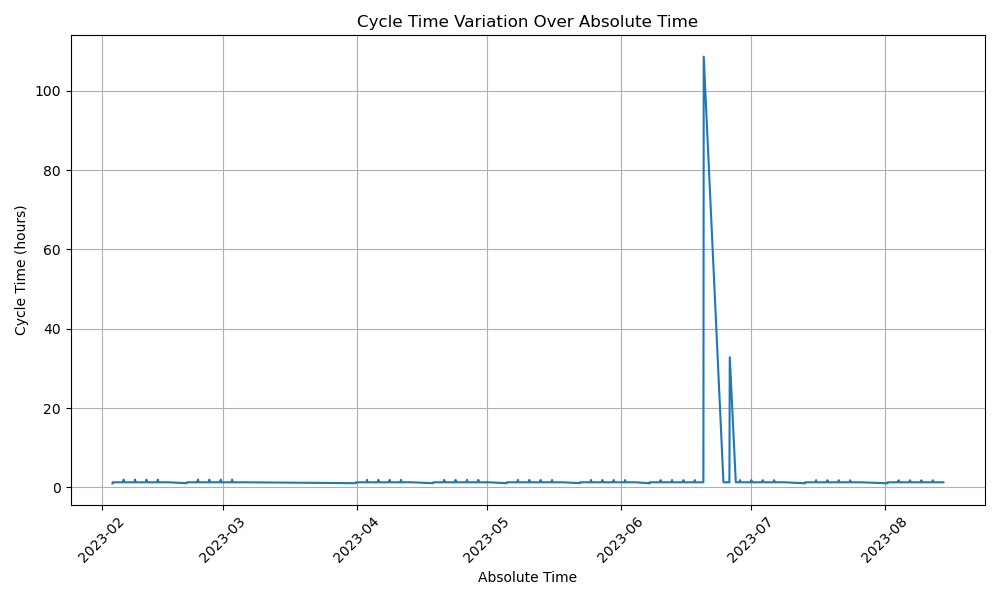

In [14]:
cycle_times = []
cycle_start_times = []
start_idx = False

for i in tqdm(range(len(df_file) - 1), desc="Calculating cycle times"):
    if df_file['Schedule_Step_ID'].iloc[i] == 1 and not start_idx:
        start_time = df_file['Absolute_Time[yyyy-mm-dd hh:mm:ss]'].iloc[i]
        start_idx = True  
    
    if start_idx and df_file['Schedule_Step_ID'].iloc[i] == 2:
        end_time = df_file['Absolute_Time[yyyy-mm-dd hh:mm:ss]'].iloc[i]
        cycle_times.append((end_time - start_time).total_seconds() / 3600) 
        cycle_start_times.append(start_time) 
        start_idx = False

plt.figure(figsize=(10, 6))
plt.plot(cycle_start_times, cycle_times)
plt.xlabel("Absolute Time")
plt.ylabel("Cycle Time (hours)")
plt.title("Cycle Time Variation Over Absolute Time")
plt.grid(True)
plt.xticks(rotation=45)  
plt.tight_layout()     
plt.show()

In [15]:
cycle_data = pd.DataFrame({
    'Cycle Start Time': cycle_start_times,
    'Cycle Time (hours)': cycle_times
})

cycle_data.to_csv("cycle_data.csv", index=False)